Evaluation Script for trained Resnet Models

In [3]:
import torch
from dataloader import *
from CNN_Models import *
from CNN_Training import *
from model_io import *
from utils.constants import *

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_plot(cm, names, title = ""):
    # Create a figure with a larger size
    plt.figure(figsize=(10, 8))

    # Create heatmap of confusion matrix
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                cmap='Blues',  # Use blue color scheme
                xticklabels=names,  # Use vessel type names for x-axis
                yticklabels=names)  # Use vessel type names for y-axis

    # Customize the plot
    plt.title('Confusion Matrix - ' + title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to prevent label cutoff

    # Show the plot
    plt.show()

Obtain the data loader for the vessel activity prediction task

In [6]:
current_path = "../"
image_path = current_path + "data/images_activity"
label_path = current_path + "data/activity_label.csv"

(train, valid) = get_activity_datasets(label_path, image_path, 16) # Use batch size of 16
model = get_resnet18_classifier(ACT_N_CLASSES, pretrained=False, dropout=0.2)

In [7]:
device = torch.device("cpu")
model_path = "model/resnet-18-dropout-overfit.pth"
logs = load_from_checkpoint(model_path, model)
model = model.to(device) # Send the model to cpu for inference

Obtain the predictions given by the model (maybe slow on CPU)

In [8]:
def predict(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, leave=False):
            out = model(images)
            preds = list(torch.argmax(out, dim = 1))
            true_labels.extend(targets)
            pred_labels.extend(preds)
            
    return true_labels, pred_labels

train_label, train_preds = predict(model, train)
valid_label, valid_preds = predict(model,valid)
            

Validation Accuracies for Activity

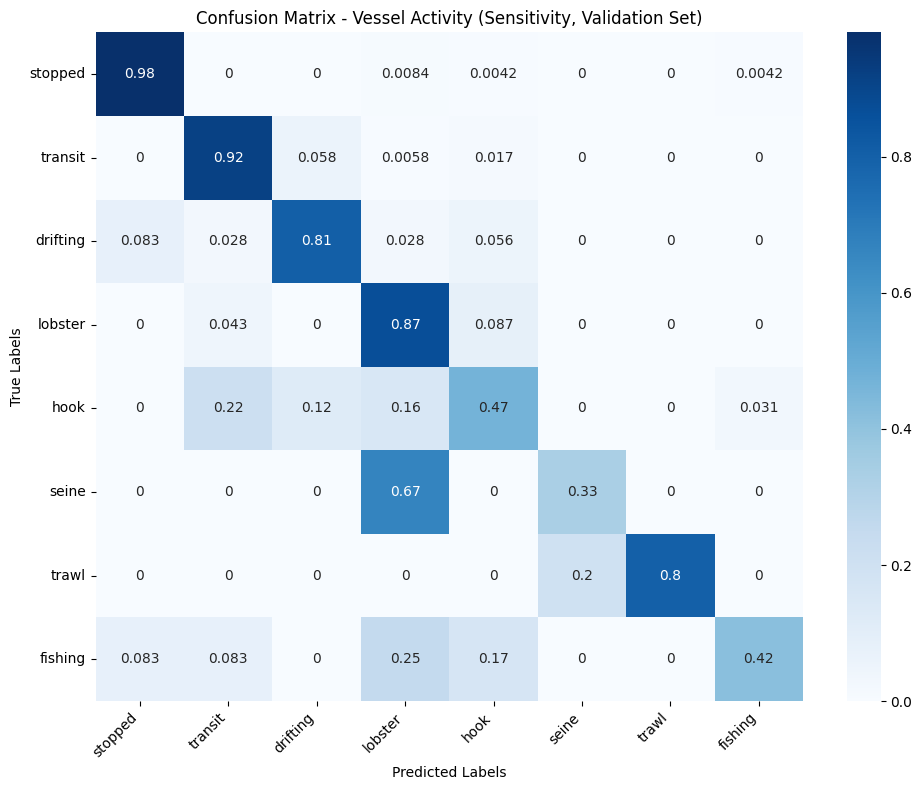

In [15]:
cm = confusion_matrix(valid_label, valid_preds)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)
confusion_matrix_plot(cm_normalized, ACTIVITIES, "Vessel Activity (Sensitivity, Validation Set)")

In [16]:
print(classification_report(valid_label, valid_preds, target_names=ACTIVITIES))
print(classification_report(train_label, train_preds, target_names=ACTIVITIES))

              precision    recall  f1-score   support

     stopped       0.98      0.98      0.98       238
     transit       0.94      0.92      0.93       172
    drifting       0.67      0.81      0.73        36
     lobster       0.59      0.87      0.70        23
        hook       0.60      0.47      0.53        32
       seine       0.50      0.33      0.40         3
       trawl       1.00      0.80      0.89         5
     fishing       0.71      0.42      0.53        12

    accuracy                           0.89       521
   macro avg       0.75      0.70      0.71       521
weighted avg       0.90      0.89      0.89       521

              precision    recall  f1-score   support

     stopped       1.00      1.00      1.00       905
     transit       1.00      0.97      0.99       695
    drifting       0.90      1.00      0.95       155
     lobster       1.00      1.00      1.00       115
        hook       1.00      1.00      1.00        94
       seine       1.00 

Do the same thing for the type prediction model

In [8]:
current_path = ""
image_path = current_path + "data/images_type"
label_path = current_path + "data/type_label.csv"

(train_type, valid_type) = get_type_datasets(label_path, image_path, 16) # Use batch size of 16
model_type = get_resnet18_classifier(ACT_N_CLASSES, pretrained=False, dropout=0.2)

In [9]:
device = torch.device("cpu")
model_path = "model/resnet-18-type-10epoch.pth"
logs = load_from_checkpoint(model_path, model_type)
model_type = model_type.to(device) # Send the model to cpu for inference
train_label_type, train_preds_type = predict(model_type, train_type)
valid_label_type, valid_preds_type = predict(model_type, valid_type)

Validation Accuracy for Type

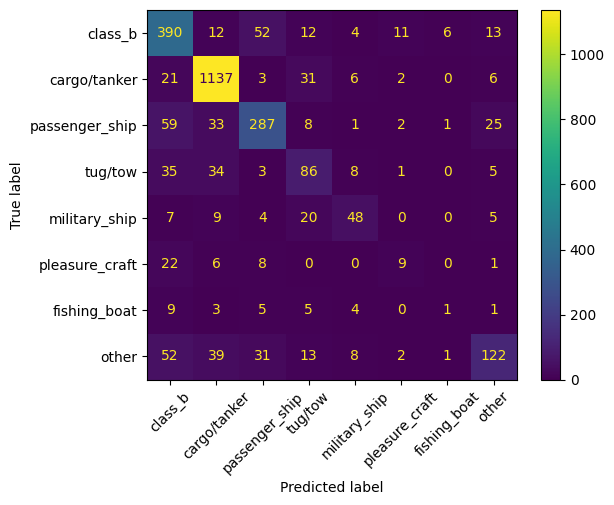

In [10]:
cm = confusion_matrix(valid_label_type, valid_preds_type)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TYPES)
disp.plot(xticks_rotation=45)

In [11]:
print(classification_report(valid_label_type, valid_preds_type, target_names=TYPES))

                precision    recall  f1-score   support

       class_b       0.66      0.78      0.71       500
  cargo/tanker       0.89      0.94      0.92      1206
passenger_ship       0.73      0.69      0.71       416
       tug/tow       0.49      0.50      0.50       172
 military_ship       0.61      0.52      0.56        93
pleasure_craft       0.33      0.20      0.25        46
  fishing_boat       0.11      0.04      0.05        28
         other       0.69      0.46      0.55       268

      accuracy                           0.76      2729
     macro avg       0.56      0.51      0.53      2729
  weighted avg       0.75      0.76      0.75      2729

